# NLP with Disaster Tweets (Mini-Project)

## The Problem and Data

The goal of this project is to build a machine learning model that predicts which tweets are about real disasters and which one’s aren’t. A dataset of 10,000 tweets that were hand classified has been provided. According to the project main page, the dataset was created by the company figure-eight and originally shared on their [‘Data For Everyone’ website](https://www.figure-eight.com/data-for-everyone/).

In this project, Keras will be used to build and train RNN (LSTM) models.

## Environment Setup, EDA and Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import emoji
import re
import nltk
nltk.download("wordnet")
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
!pip install contractions
import contractions
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from keras.optimizers import Adam

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [2]:
data = pd.read_csv("../input/nlp-getting-started/train.csv")
data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


Only below columns will be used:
* `text`: the text of the tweet
* `target`: this denotes whether a tweet is about a real disaster (`1`) or not (`0`)

In [3]:
data = data[["text", "target"]]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


[Text(0, 0, '4342'), Text(0, 0, '3271')]

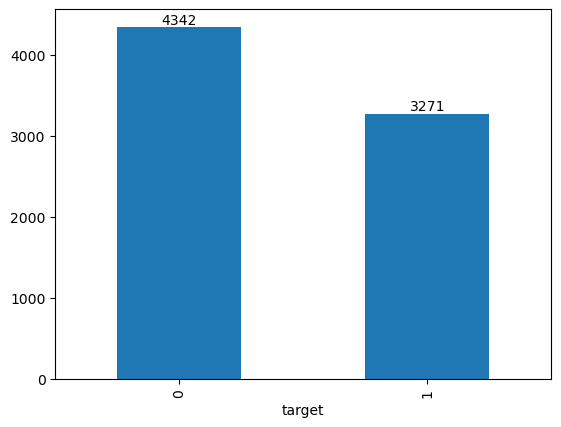

In [4]:
p = data.groupby("target")["target"].count().plot(kind="bar")
p.bar_label(p.containers[0])

There are **7613** tweets in the training dataset, with **3271** (~43%) are about real disaster.

### Word count distributuion

In [5]:
word_len_dis = data[data["target"]==1]["text"].str.split().map(lambda x : len(x))
word_len_non_dis = data[data["target"]==0]["text"].str.split().map(lambda x : len(x))

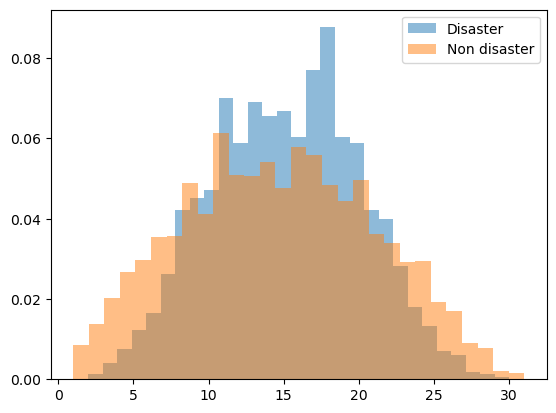

In [6]:
plt.hist(word_len_dis, 29, density=True, alpha=0.5, label="Disaster")
plt.hist(word_len_non_dis, 29,density=True, alpha=0.5, label="Non disaster")
plt.legend(loc="upper right")
plt.show()

The average word count for both categories are similar, while the variance for non-disaster tweets is higher.

### Text pre-processing

Below clean-up actions will be applyed on the tweets. Lemmatization will be done using the NLTK library.

* Convert to lowercase
* Remove emojis
* Remove URLs
* Remove mentions
* Remove digits
* Fix contractions
* Remove punctuations
* Lemmatization
* Remove stopwords
* Remove single letters

In [7]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    result = text.lower()
    result = emoji.replace_emoji(result, replace="")
    result = re.sub(r"https?://\S+|www\.\S+|http?://\S+", "", result)
    result = re.sub(r"@\S+", "", result)
    result = re.sub(r"[0-9]", "", result)
    result = re.sub(r"|û|ò|ª|è|ñ", "", result)
    result = contractions.fix(result)
    result = result.translate(str.maketrans("", "", string.punctuation))
    
    result = result.split()
    result = [word for word in result if
              word != "rt" and
              word != "amp"]
    result = [lemmatizer.lemmatize(word) for word in result if word not in stopwords.words("english")]
    result = [word for word in result if len(word) > 1]
    
    return " ".join(result)

In [8]:
data["clean_text"] = data["text"].apply(clean_text)
data = data[["text", "clean_text", "target"]]
data.head()

,text,clean_text,target
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive,1
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...,1
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...,1
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...,1


In [9]:
temp = set()
data["clean_text"].str.split().apply(temp.update)
vocab_size_full = len(temp)
print(f"Distinct word count of clean_text: {vocab_size_full}")

Distinct word count of clean_text: 13297


### Word cloud after text pre-processing

In [11]:
def wordcloud(data, title):
    words = " ".join(data["clean_text"].astype("str").tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords=stopwords, width=1024, height=512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

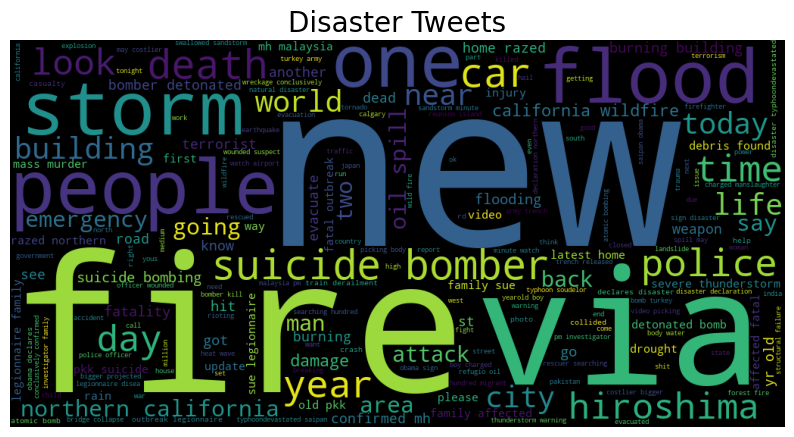

In [12]:
wordcloud(data[data["target"] == 1], "Disaster Tweets")

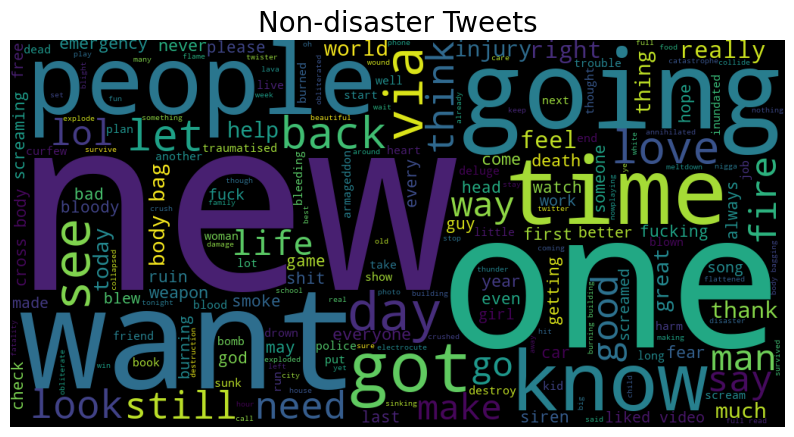

In [13]:
wordcloud(data[data["target"] == 0], "Non-disaster Tweets")

Using the Keras utility to tokenize the texts.

In [14]:
tokenizer = Tokenizer(num_words=vocab_size_full)
tokenizer.fit_on_texts(data["clean_text"])
sequences = tokenizer.texts_to_sequences(data["clean_text"])

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

text_pad_seq = pad_sequences(sequences, padding="post")

labels = data["target"]

print(f"Shape of input: {text_pad_seq.shape}")
print(f"Shape of label: {labels.shape}")

MAX_SEQUENCE_LENGTH = text_pad_seq.shape[1]

Found 13297 unique tokens.
Shape of input: (7613, 23)
Shape of label: (7613,)


Spliting the dataset into train and test set with a 8:2 ratio.

In [15]:
seed = 100
x_train, x_test, y_train, y_test = train_test_split(text_pad_seq, labels, test_size=0.2, random_state=seed)
print(f"train: {x_train.shape[0]}. test: {x_test.shape[0]}")

train: 6090. test: 1523


## Model Building & Training

### Word embedding

GloVe (Global Vectors for Word Representation) will be used for word embedding. GloVe is a type of word embedding model that is commonly used in natural language processing and text analysis. It is designed to capture the meaning of words by representing them as dense, low-dimensional vectors. The key idea behind GloVe is to leverage the co-occurrence statistics of words in a large corpus of text to learn the word embeddings. The basic assumption is that words that co-occur frequently in the same context tend to have similar meanings. The GloVe model constructs a global word-word co-occurrence matrix from the corpus, which captures the frequency of each word's co-occurrence with every other word in the corpus. It then factorizes this matrix using singular value decomposition (SVD) to obtain the word embeddings.

[Pre-trained GloVe models](https://www.kaggle.com/datasets/anindya2906/glove6b) with 50, 100, 200, 300 features are available. The one with 100 features will be used.

In [16]:
embeddings_index = {}
with open("/kaggle/input/glove6b/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [17]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### LSTM model

First, let's build and train a vanilla LSTM model.

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that is commonly used in deep learning for sequential data modeling. It is designed to address the exploding/vanishing gradient problem in traditional RNNs, which occurs when gradients become too large/small as they propagate through the network, making it difficult to learn long-term dependencies in sequential data.

In [18]:
model1 = Sequential(name="model1")

model1.add(Embedding(len(word_index)+1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
model1.add(LSTM(32, return_sequences=True))
model1.add(LSTM(32))
model1.add(Dense(64, activation="relu"))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation="sigmoid"))

model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           1329800   
                                                                 
 lstm (LSTM)                 (None, 23, 32)            17024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,357,321
Trainable params: 27,521
Non-trainab

In [19]:
learning_rate = 0.0001
epochs = 10

opt = Adam(learning_rate=learning_rate)
model1.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
hist1 = model1.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/10
191/191 [==============================] - 8s 27ms/step - loss: 0.6567 - accuracy: 0.6560 - val_loss: 0.5565 - val_accuracy: 0.7564
Epoch 2/10
191/191 [==============================] - 4s 22ms/step - loss: 0.5181 - accuracy: 0.7690 - val_loss: 0.4857 - val_accuracy: 0.7886
Epoch 3/10
191/191 [==============================] - 4s 22ms/step - loss: 0.4840 - accuracy: 0.7860 - val_loss: 0.4665 - val_accuracy: 0.7971
Epoch 4/10
191/191 [==============================] - 4s 22ms/step - loss: 0.4715 - accuracy: 0.7952 - val_loss: 0.4568 - val_accuracy: 0.7997
Epoch 5/10
191/191 [==============================] - 4s 22ms/step - loss: 0.4642 - accuracy: 0.7995 - val_loss: 0.4504 - val_accuracy: 0.8056
Epoch 6/10
191/191 [==============================] - 4s 22ms/step - loss: 0.4566 - accuracy: 0.8054 - val_loss: 0.4463 - val_accuracy: 0.8050
Epoch 7/10
191/191 [==============================] - 4s 22ms/step - loss: 0.4501 - accuracy: 0.8064 - val_loss: 0.4428 - val_accuracy: 0.8017

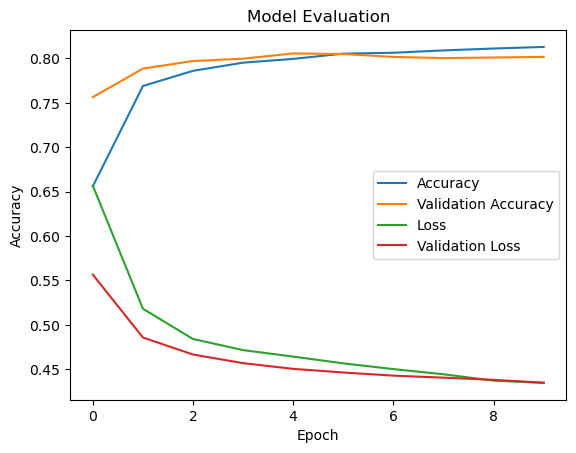

In [20]:
plt.plot(hist1.history["accuracy"])
plt.plot(hist1.history["val_accuracy"])
plt.plot(hist1.history["loss"])
plt.plot(hist1.history["val_loss"])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

### Bidirectional LSTM model

Next, let's try to build a bidirectional LSTM model and see if there is any gain in performance.

The key difference between LSTM and bidirectional LSTM lies in the direction of the information flow. In a regular LSTM, information flows only from past to future, and the cell state and hidden state are updated based on the past information. In contrast, bidirectional LSTMs process the sequence both forward and backward, allowing them to capture information from both past and future contexts. This means that bidirectional LSTMs have access to both the past and future context of a given point in the sequence, which can be beneficial in certain tasks such as machine translation or speech recognition.

In [21]:
model2 = Sequential(name="model2")

model2.add(Embedding(len(word_index)+1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
model2.add(Bidirectional(LSTM(32, return_sequences=True)))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation="sigmoid"))

model2.summary()

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 100)           1329800   
                                                                 
 bidirectional (Bidirectiona  (None, 23, 64)           34048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65   

In [22]:
model2.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
hist2 = model2.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/10
191/191 [==============================] - 12s 33ms/step - loss: 0.5089 - accuracy: 0.7721 - val_loss: 0.4581 - val_accuracy: 0.7965
Epoch 2/10
191/191 [==============================] - 5s 26ms/step - loss: 0.4570 - accuracy: 0.7975 - val_loss: 0.4427 - val_accuracy: 0.7997
Epoch 3/10
191/191 [==============================] - 5s 27ms/step - loss: 0.4442 - accuracy: 0.8041 - val_loss: 0.4426 - val_accuracy: 0.8050
Epoch 4/10
191/191 [==============================] - 5s 26ms/step - loss: 0.4379 - accuracy: 0.8120 - val_loss: 0.4335 - val_accuracy: 0.7997
Epoch 5/10
191/191 [==============================] - 5s 28ms/step - loss: 0.4301 - accuracy: 0.8144 - val_loss: 0.4303 - val_accuracy: 0.8017
Epoch 6/10
191/191 [==============================] - 5s 26ms/step - loss: 0.4232 - accuracy: 0.8179 - val_loss: 0.4299 - val_accuracy: 0.8011
Epoch 7/10
191/191 [==============================] - 5s 28ms/step - loss: 0.4179 - accuracy: 0.8225 - val_loss: 0.4292 - val_accuracy: 0.803

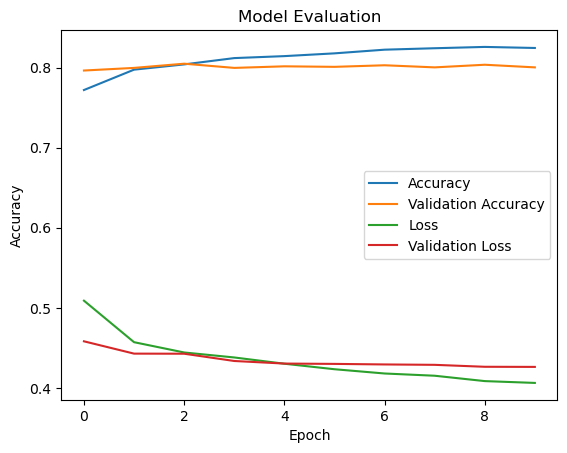

In [23]:
plt.plot(hist2.history["accuracy"])
plt.plot(hist2.history["val_accuracy"])
plt.plot(hist2.history["loss"])
plt.plot(hist2.history["val_loss"])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

The accuracy of the bidirectional model is similar to the regular model.

### Model / hyperparameter tuning

Let's try to add a few more hidden layers and see how the accuracy changes.

In [24]:
model3 = Sequential(name="model3")

model3.add(Embedding(len(word_index)+1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
model3.add(Bidirectional(LSTM(32, return_sequences=True)))
model3.add(Bidirectional(LSTM(32, return_sequences=True)))
model3.add(Bidirectional(LSTM(32, return_sequences=True)))
model3.add(Bidirectional(LSTM(32, return_sequences=True)))
model3.add(Bidirectional(LSTM(32)))
model3.add(Dense(64, activation="relu"))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation="sigmoid"))

model3.summary()

Model: "model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 100)           1329800   
                                                                 
 bidirectional_2 (Bidirectio  (None, 23, 64)           34048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 23, 64)           24832     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 23, 64)           24832     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 23, 64)           24832     
 nal)                                                       

In [25]:
model3.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
hist3 = model3.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/10
191/191 [==============================] - 28s 77ms/step - loss: 0.5175 - accuracy: 0.7557 - val_loss: 0.4446 - val_accuracy: 0.8011
Epoch 2/10
191/191 [==============================] - 11s 59ms/step - loss: 0.4536 - accuracy: 0.7990 - val_loss: 0.4391 - val_accuracy: 0.8063
Epoch 3/10
191/191 [==============================] - 11s 60ms/step - loss: 0.4422 - accuracy: 0.8059 - val_loss: 0.4281 - val_accuracy: 0.8070
Epoch 4/10
191/191 [==============================] - 12s 64ms/step - loss: 0.4336 - accuracy: 0.8113 - val_loss: 0.4244 - val_accuracy: 0.8122
Epoch 5/10
191/191 [==============================] - 12s 64ms/step - loss: 0.4257 - accuracy: 0.8131 - val_loss: 0.4227 - val_accuracy: 0.8129
Epoch 6/10
191/191 [==============================] - 13s 66ms/step - loss: 0.4175 - accuracy: 0.8176 - val_loss: 0.4193 - val_accuracy: 0.8142
Epoch 7/10
191/191 [==============================] - 12s 64ms/step - loss: 0.4115 - accuracy: 0.8236 - val_loss: 0.4183 - val_accuracy:

Seems adding LSTM layers doesn't improve the model performance.

Next, let's try to increase the dropout rate to 0.4.

In [26]:
model4 = Sequential(name="model4")

model4.add(Embedding(len(word_index)+1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
model4.add(Bidirectional(LSTM(32, return_sequences=True)))
model4.add(Bidirectional(LSTM(32)))
model4.add(Dense(64, activation="relu"))
model4.add(Dropout(0.4))
model4.add(Dense(1, activation="sigmoid"))

model4.summary()

Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 23, 100)           1329800   
                                                                 
 bidirectional_7 (Bidirectio  (None, 23, 64)           34048     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65   

In [27]:
model4.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
hist4 = model4.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/10
191/191 [==============================] - 12s 34ms/step - loss: 0.5262 - accuracy: 0.7509 - val_loss: 0.4480 - val_accuracy: 0.7991
Epoch 2/10
191/191 [==============================] - 5s 27ms/step - loss: 0.4605 - accuracy: 0.7908 - val_loss: 0.4338 - val_accuracy: 0.7991
Epoch 3/10
191/191 [==============================] - 5s 27ms/step - loss: 0.4450 - accuracy: 0.7998 - val_loss: 0.4289 - val_accuracy: 0.8043
Epoch 4/10
191/191 [==============================] - 5s 29ms/step - loss: 0.4376 - accuracy: 0.8049 - val_loss: 0.4254 - val_accuracy: 0.8063
Epoch 5/10
191/191 [==============================] - 5s 28ms/step - loss: 0.4296 - accuracy: 0.8103 - val_loss: 0.4248 - val_accuracy: 0.8037
Epoch 6/10
191/191 [==============================] - 5s 29ms/step - loss: 0.4242 - accuracy: 0.8125 - val_loss: 0.4214 - val_accuracy: 0.8063
Epoch 7/10
191/191 [==============================] - 5s 27ms/step - loss: 0.4191 - accuracy: 0.8172 - val_loss: 0.4212 - val_accuracy: 0.808

There isn't any obvious improvement in model performance.

Next, let's try to replace the dropout layer with a batch normalization layer.

In [28]:
model5 = Sequential(name="model5")

model5.add(Embedding(len(word_index)+1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
model5.add(Bidirectional(LSTM(32, return_sequences=True)))
model5.add(Bidirectional(LSTM(32)))
model5.add(Dense(64, activation="relu"))
model5.add(BatchNormalization())
model5.add(Dense(1, activation="sigmoid"))

model5.summary()

Model: "model5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 23, 100)           1329800   
                                                                 
 bidirectional_9 (Bidirectio  (None, 23, 64)           34048     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                            

In [29]:
model5.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
hist5 = model5.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/10
191/191 [==============================] - 13s 34ms/step - loss: 0.4928 - accuracy: 0.7691 - val_loss: 0.5921 - val_accuracy: 0.7735
Epoch 2/10
191/191 [==============================] - 5s 28ms/step - loss: 0.4422 - accuracy: 0.8005 - val_loss: 0.4964 - val_accuracy: 0.7997
Epoch 3/10
191/191 [==============================] - 6s 29ms/step - loss: 0.4231 - accuracy: 0.8130 - val_loss: 0.4542 - val_accuracy: 0.7984
Epoch 4/10
191/191 [==============================] - 5s 28ms/step - loss: 0.4130 - accuracy: 0.8171 - val_loss: 0.4306 - val_accuracy: 0.8011
Epoch 5/10
191/191 [==============================] - 5s 26ms/step - loss: 0.4004 - accuracy: 0.8225 - val_loss: 0.4284 - val_accuracy: 0.7945
Epoch 6/10
191/191 [==============================] - 5s 27ms/step - loss: 0.3960 - accuracy: 0.8273 - val_loss: 0.4300 - val_accuracy: 0.7938
Epoch 7/10
191/191 [==============================] - 5s 26ms/step - loss: 0.3809 - accuracy: 0.8388 - val_loss: 0.4299 - val_accuracy: 0.795

Again, there isn't any significant change in model performance.

## Conclusion

Validation accuracy after 10 epochs:

|  | Validation accuracy |
| --- | --- |
| 1. Regular LSTM | 0.8017 |
| 2.1 Bidirectional LSTM | 0.8004 |
| 2.2 Add LSTM layers | 0.8063 |
| 2.3 Increase dropout rate to 0.4 | 0.8116 |
| 2.4 Replace dropout with batch normalization | 0.7997 |

All models perform similarly with validation accuracy around 0.8 which is not too bad.

Some potential ways to improve the performance including:

* Using other word embedding methods
* Using more advanced models like BERT

## Submission

### Regular LSTM

In [30]:
data_sub = pd.read_csv("../input/nlp-getting-started/test.csv")
data_sub["clean_text"] = data_sub["text"].apply(clean_text)

sequences_sub = tokenizer.texts_to_sequences(data_sub["clean_text"])
text_pad_seq_sub = pad_sequences(sequences_sub, padding="post", maxlen=23)

In [31]:
predictions1 = model1.predict(text_pad_seq_sub, verbose=1)
print(predictions1)

102/102 [==============================] - 1s 7ms/step
[[0.9140042 ]
 [0.7456166 ]
 [0.9078156 ]
 ...
 [0.7124507 ]
 [0.39348412]
 [0.38943696]]


In [32]:
predictions_t1 = np.transpose(predictions1)[0]

submission_df1 = pd.DataFrame()
submission_df1["id"] = data_sub["id"]
submission_df1["target"] = list(map(lambda x: 0 if x < 0.5 else 1, predictions_t1))

submission_df1.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [33]:
submission_df1.to_csv("submission1.csv", index=False)

The public score of model 1 (regular LSTM) is **0.78547**.

### Bidirectional LSTM

In [34]:
predictions2 = model2.predict(text_pad_seq_sub, verbose=1)
print(predictions2)

102/102 [==============================] - 2s 9ms/step
[[0.8775496 ]
 [0.7478923 ]
 [0.95655507]
 ...
 [0.7825497 ]
 [0.6510325 ]
 [0.49472386]]


In [35]:
predictions_t2 = np.transpose(predictions2)[0]

submission_df2 = pd.DataFrame()
submission_df2["id"] = data_sub["id"]
submission_df2["target"] = list(map(lambda x: 0 if x < 0.5 else 1, predictions_t2))

submission_df2.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [36]:
submission_df2.to_csv("submission2.csv", index=False)

The public score of model 2 (bidirectional LSTM) is **0.80049**.